## Importing modules

In [103]:
from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label
from moviepy.editor import VideoFileClip
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time

%matplotlib inline

## Data set

In [2]:
yes_cars = glob.glob('./data_set/vehicles/**/*.png')
no_cars = glob.glob('./data_set/non-vehicles/**/*.png')
print("There are %d cars images." %len(yes_cars))
print("There are %d non cars images." %len(no_cars))

There are 8792 cars images.
There are 8968 non cars images.


## Visualizing Data

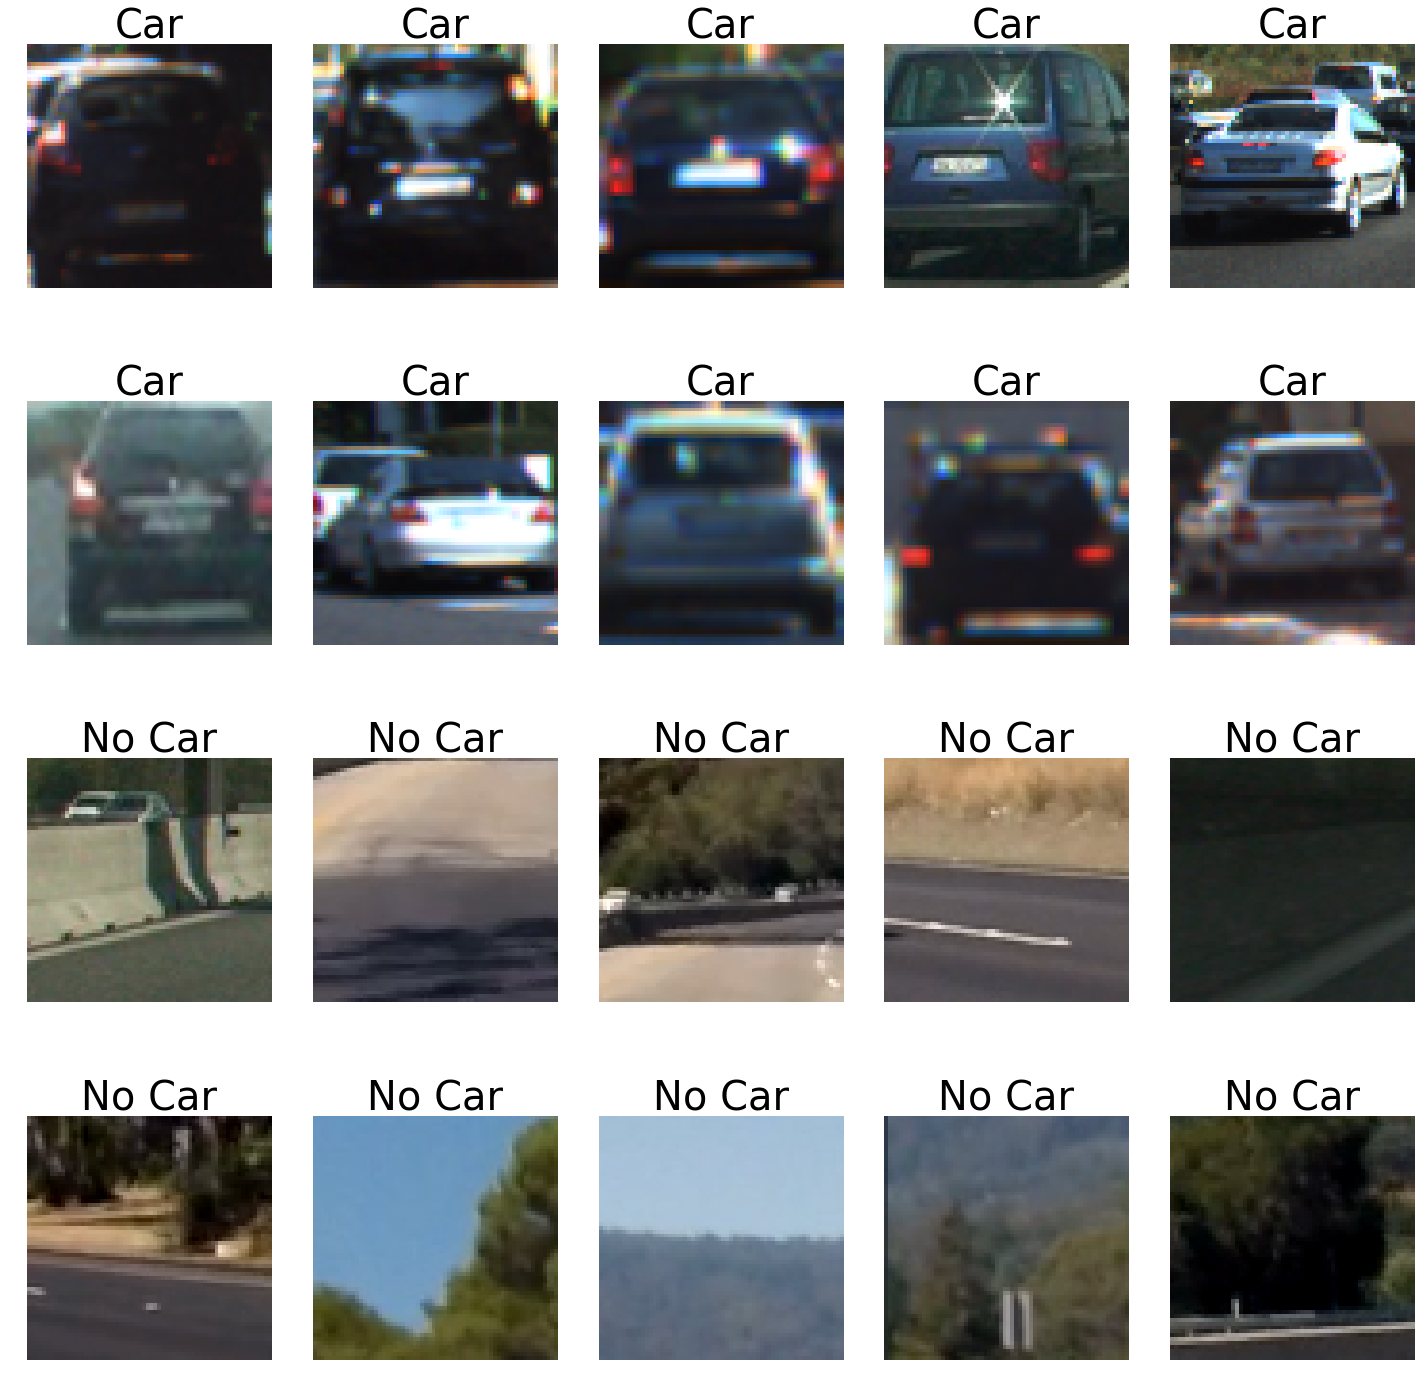

In [3]:
# Reading and visualization of car and not car
f, ax = plt.subplots(4,5, figsize=(20,20))
ax = ax.ravel()
f.tight_layout()
for i in range(10):
    ax[i].imshow(mpimg.imread(yes_cars[np.random.randint(0,len(yes_cars))]))
    ax[i].set_title('Car', fontsize=40)
    ax[i].axis('off')
    ax[i+10].imshow(mpimg.imread(no_cars[np.random.randint(0,len(no_cars))]))
    ax[i+10].set_title('No Car', fontsize=40)
    ax[i+10].axis('off')
plt.show()


In [4]:
# Define a function to return HOG features with its respectives parameters
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualise=True, feature_vector=feature_vec)
        return features, hog_image
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualise=False, feature_vector=feature_vec)
        return features

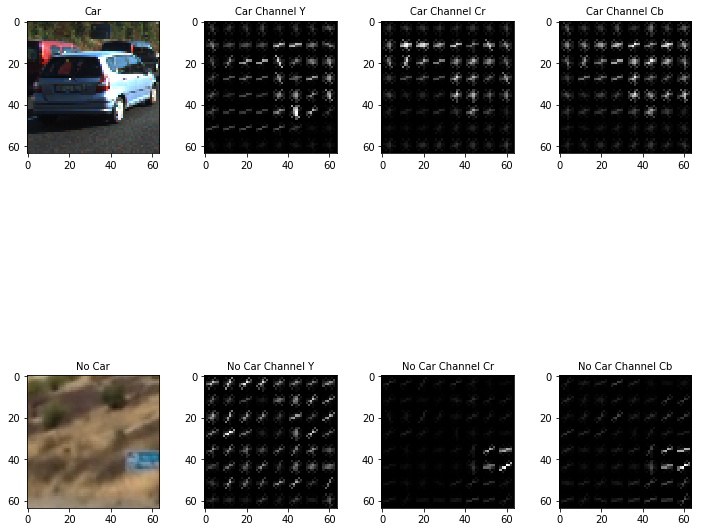

In [137]:

# Define HOG parameters
orient = 9
pix_per_cell = 8
cell_per_block = 2

img1 = mpimg.imread(yes_cars[90])
img2 = mpimg.imread(no_cars[16])

# Convert to Channel HSV, for example.
img1_ = cv2.cvtColor(img1, cv2.COLOR_RGB2YCrCb)
img2_ = cv2.cvtColor(img2, cv2.COLOR_RGB2YCrCb)


# Call our function with vis=True to see an image output
_, hog_image1r = get_hog_features(img1_[:,:,0], orient, pix_per_cell, cell_per_block, vis=True)
_, hog_image1g = get_hog_features(img1_[:,:,1], orient, pix_per_cell, cell_per_block, vis=True)
_, hog_image1b = get_hog_features(img1_[:,:,2], orient, pix_per_cell, cell_per_block, vis=True)

_, hog_image2r = get_hog_features(img2_[:,:,0], orient, pix_per_cell, cell_per_block, vis=True)
_, hog_image2g = get_hog_features(img2_[:,:,1], orient, pix_per_cell, cell_per_block, vis=True)
_, hog_image2b = get_hog_features(img2_[:,:,2], orient, pix_per_cell, cell_per_block, vis=True)


# Plot the examples
f, ax = plt.subplots(2, 4, figsize=(10,10))
f.tight_layout()
ax = ax.ravel()
ax[0].imshow(img1)
ax[0].set_title('Car', fontsize=10)
ax[1].imshow(hog_image1r,cmap='gray')
ax[1].set_title('Car Channel Y', fontsize=10)
ax[2].imshow(hog_image1g,cmap='gray')
ax[2].set_title('Car Channel Cr', fontsize=10)
ax[3].imshow(hog_image1b,cmap='gray')
ax[3].set_title('Car Channel Cb', fontsize=10)

ax[4].imshow(img2)
ax[4].set_title('No Car', fontsize=10)
ax[5].imshow(hog_image2r,cmap='gray')
ax[5].set_title('No Car Channel Y', fontsize=10)
ax[6].imshow(hog_image2g,cmap='gray')
ax[6].set_title('No Car Channel Cr', fontsize=10)
ax[7].imshow(hog_image2b,cmap='gray')
ax[7].set_title('No Car Channel Cb', fontsize=10)
plt.show()

## Extracting features

In [8]:
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, cspace='RGB', orient=9, pix_per_cell=8, cell_per_block=2, hog_channel=0):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'LAB':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: 
            feature_image = np.copy(image)      
       
        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)# Append the new feature vector to the features list
        # Append the new feature vector to the features list
        features.append(hog_features)
    # Return list of feature vectors
    return features

## HOG Classify

In [94]:
colorspace = 'YCrCb'
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = "ALL" 

t=time.time()
car_features = extract_features(yes_cars, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
notcar_features = extract_features(no_cars, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')

X = np.vstack((car_features, notcar_features))
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=np.random.randint(0, 100))

print('Using:',orient,'orientations',pix_per_cell, 'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

/home/leonardo/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


96.56 Seconds to extract HOG features...
Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 5292


### Configuration and Extract Features Time

| Index | Color Space | Orientation   | Pixels Per Cell | Cells Per Block	| HOG Channel | Extract Features Time(s) |	
|:---:|:----------------:|:-------------:|:---:|:---:|:---:|:---:|
| 1   | RGB       | 9  | 8 | 2 | ALL | 183.05 |
| 2   | HSV       | 9  | 8 | 2 | ALL | 90.97 |
| 3   | LUV       | 9  | 8 | 2 | ALL | 273.59 |
| 4   | YCrCb     | 9  | 8 | 2 | ALL | 88.69|
| 5   | LAB       | 9  | 8 | 2 | ALL | 284.98 |
| 6   | HLS       | 9  | 8 | 2 | ALL | 91.25 |
| 7   | YUV       | 9  | 8 | 2 | ALL | 231.05|
| 8   | YUV       | 11 | 16| 2 | ALL | 70.71 |
| 9   | HLS       | 11 | 16| 2 | ALL | 206.67 |
| 10  | YCrCb     | 11  | 16 | 2 | ALL | 63.53|
| 11  | YUV       | 9 | 16| 2 | ALL | 61.27 |

## Classifying with SVM

In [87]:
# It is necessary when there are many np.nan in X_train and X_test.
X_train = np.nan_to_num(X_train)
X_test = np.nan_to_num(X_test)

In [95]:
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')

# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

# Check the prediction time for a single sample
t=time.time()
n_predict = 10 # Number of examples

print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

7.68 Seconds to train SVC...
Test Accuracy of SVC =  0.9851
My SVC predicts:  [ 0.  1.  1.  0.  1.  1.  0.  1.  0.  0.]
For these 10 labels:  [ 0.  1.  0.  0.  1.  1.  0.  1.  0.  0.]
0.00313 Seconds to predict 10 labels with SVC


I have calculated accuracy for each configuration and I obtained that the HLS channel got considerable accuracy.

## Detect Cars In an Image Using Classifier

In [96]:
def find_cars(img, ystart, ystop, scale, svc, orient, pix_per_cell, cell_per_block, show_all_rectangles=False):
    
    #draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    rectangles = []
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
            
            test_prediction = svc.predict(hog_features.reshape(1,-1))
            
            if test_prediction == 1 or show_all_rectangles:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                #cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                rectangles.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                
    return rectangles

In [97]:
def DrawBoxes(img, boxes):
    draw_img = np.copy(img)
    for pair in boxes:
        cv2.rectangle(draw_img, pair[0], pair[1], (0,0,255), 6)
    return draw_img

## Combining Sliding Window Searches

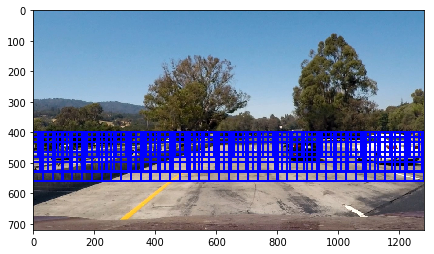

In [129]:
test_img = mpimg.imread('./test_images/test1.jpg')

rectangles = []

colorspace = 'YCrCb'
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL'


ystart = [400, 416, 400, 432, 400, 432, 400, 464]
ystop =  [464, 480, 496, 528, 528, 560, 596, 660]
scale =  [1.0, 1.0, 1.5, 1.5, 2.0, 2.0, 3.5, 3.5]

for a, b, c in zip(ystart, ystop, scale):
    rectangles.append(find_cars(test_img, a, b, c, svc, orient, pix_per_cell, cell_per_block,show_all_rectangles=True))
    
rectangles = [elem for subdir in rectangles for elem in subdir] 

plt.figure(figsize=(7,10))
plt.imshow(DrawBoxes(test_img, rectangles))
plt.show()

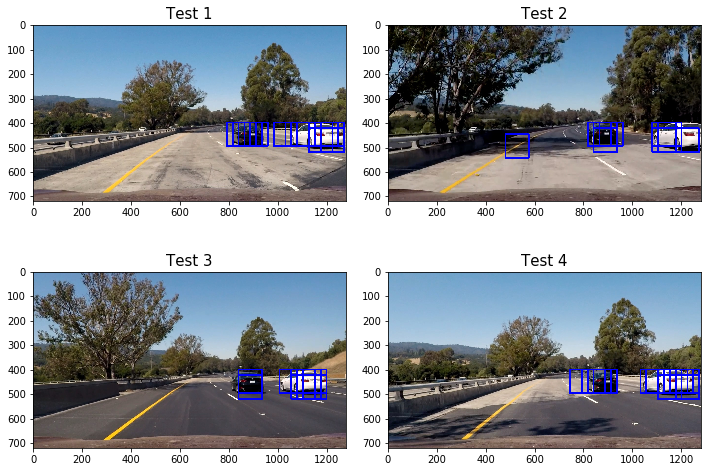

In [130]:
test_img_1 = mpimg.imread('./test_images/test1.jpg')
test_img_2 = mpimg.imread('./test_images/test5.jpg')
test_img_3 = mpimg.imread('./test_images/test6.jpg')
test_img_4 = mpimg.imread('./test_images/test4.jpg')

ystart = 400
ystop = 656
scale = 1.5
colorspace = 'YCrCb'
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL'

rectangles_1 = find_cars(test_img_1, ystart, ystop, scale, svc, orient, pix_per_cell, cell_per_block)
rectangles_2 = find_cars(test_img_2, ystart, ystop, scale, svc, orient, pix_per_cell, cell_per_block)
rectangles_3 = find_cars(test_img_3, ystart, ystop, scale, svc, orient, pix_per_cell, cell_per_block)
rectangles_4 = find_cars(test_img_4, ystart, ystop, scale, svc, orient, pix_per_cell, cell_per_block)

out_img_1 = DrawBoxes(test_img_1, rectangles_1)
out_img_2 = DrawBoxes(test_img_2, rectangles_2)
out_img_3 = DrawBoxes(test_img_3, rectangles_3)
out_img_4 = DrawBoxes(test_img_4, rectangles_4)

# Plot the test images
f, ax = plt.subplots(2, 2, figsize=(10,7))
f.tight_layout()
ax = ax.ravel()
ax[0].imshow(out_img_1)
ax[0].set_title('Test 1', fontsize=15)
ax[1].imshow(out_img_2)
ax[1].set_title('Test 2', fontsize=15)
ax[2].imshow(out_img_3)
ax[2].set_title('Test 3', fontsize=15)
ax[3].imshow(out_img_4)
ax[3].set_title('Test 4', fontsize=15)
plt.show()

## Visualizing Heatmaps

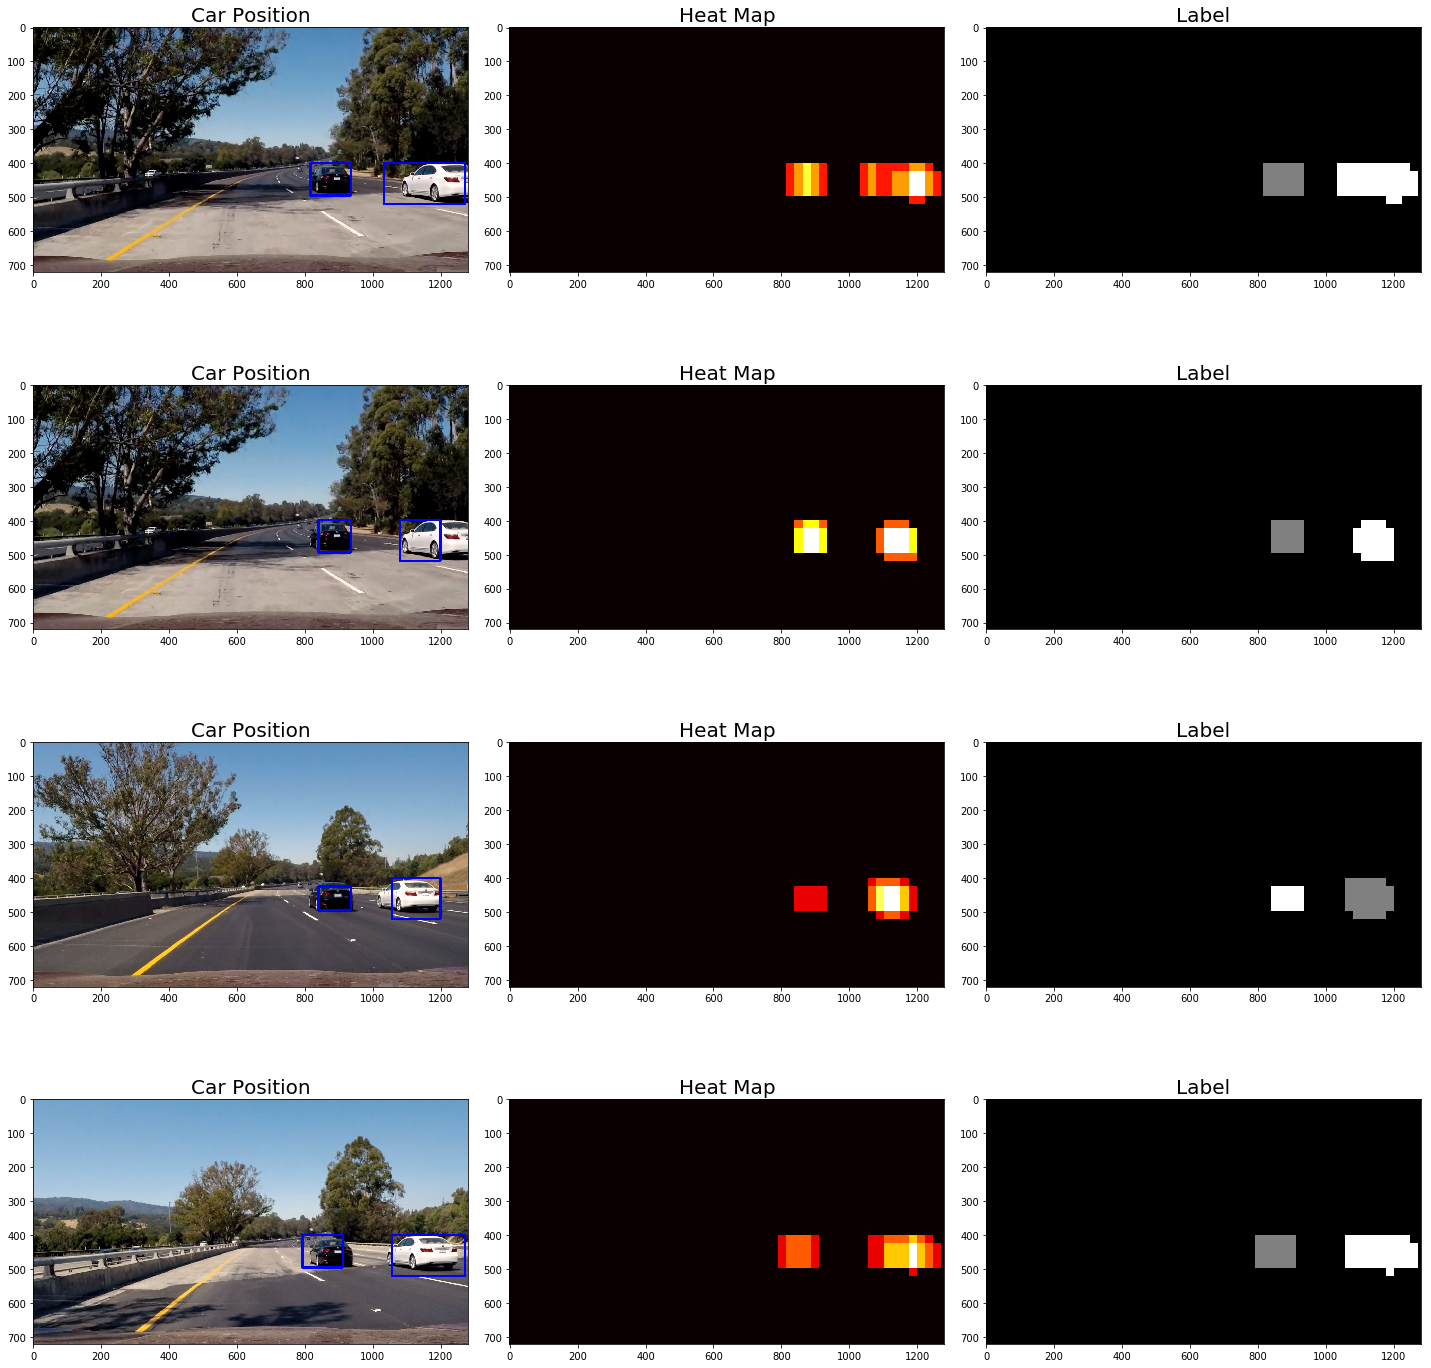

In [139]:

box_list = [rectangles_1, rectangles_2, rectangles_3, rectangles_4]
test_imgs = [test_img_1, test_img_2, test_img_3, test_img_4]

# Add heat to each box in box list
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes

# Apply threshold to help remove false positives
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

# Plot the test images
f, ax = plt.subplots(4,3, figsize=(20,20))
f.tight_layout()
ax = ax.ravel()

for i in range(4):
    heat = np.zeros_like(test_imgs[i][:,:,0]).astype(np.float)
    heat = add_heat(heat,box_list[i])
    heat = apply_threshold(heat,1)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(test_imgs[i]), labels)
    
    ax[3*i].imshow(draw_img)
    ax[3*i].set_title('Car Position', fontsize=20)
    ax[3*i+1].imshow(heatmap,cmap='hot')
    ax[3*i+1].set_title('Heat Map', fontsize=20)
    ax[3*i+2].imshow(labels[0],cmap='gray')
    ax[3*i+2].set_title('Label', fontsize=20)
plt.show()

In [132]:
def pipeline_final(img):

    rectangles = []

    colorspace = 'YCrCb'
    orient = 9
    pix_per_cell = 8
    cell_per_block = 2
    hog_channel = 'ALL'


    ystart = [400, 416, 400, 432, 400, 432, 400, 464]
    ystop =  [464, 480, 496, 528, 528, 560, 596, 660]
    scale =  [1.0, 1.0, 1.5, 1.5, 2.0, 2.0, 3.5, 3.5]

    for a, b, c in zip(ystart, ystop, scale):
        rectangles.append(find_cars(img, a, b, c, svc, orient, pix_per_cell, cell_per_block,show_all_rectangles=False))

    rectangles = [elem for subdir in rectangles for elem in subdir] 
    
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    heat = add_heat(heat,rectangles)
    heat = apply_threshold(heat,1)
    
    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)   
    
    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    
    return draw_img

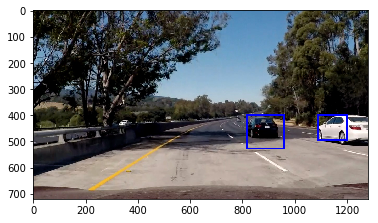

In [138]:
test_img_1 = mpimg.imread('./test_images/test5.jpg')
plt.imshow(pipeline_final(test_img_1))
plt.show()

In [134]:
test_out_file = 'test_video_out.mp4'
clip_test = VideoFileClip('test_video.mp4')
clip_test_out = clip_test.fl_image(pipeline_final)
%time clip_test_out.write_videofile(test_out_file, audio=False)

[MoviePy] >>>> Building video test_video_out.mp4
[MoviePy] Writing video test_video_out.mp4


 97%|█████████▋| 38/39 [00:19<00:00,  2.01it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_out.mp4 

CPU times: user 21.5 s, sys: 140 ms, total: 21.6 s
Wall time: 21.3 s


In [135]:
test_out_file = 'project_video_out.mp4'
clip_test = VideoFileClip('project_video.mp4')
clip_test_out = clip_test.fl_image(pipeline_final)
%time clip_test_out.write_videofile(test_out_file, audio=False)

[MoviePy] >>>> Building video project_video_out.mp4
[MoviePy] Writing video project_video_out.mp4


100%|█████████▉| 1260/1261 [12:07<00:00,  1.59it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out.mp4 

CPU times: user 13min 14s, sys: 4.29 s, total: 13min 19s
Wall time: 12min 9s
